<a href="https://colab.research.google.com/github/FranciscaHerr/AA-II-Herrera-RodriguezyBarros-Zahradnicek/blob/main/TP2_AAII_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aprendizaje Autom√°tico 2
### TP 2 - Redes Recurrentes
#### Problema 1 - Audio MNIST

## Enunciado

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a d√≠gitos hablados del 0 al 9.

**Dataset:**
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por d√≠gito por locutor.

**Objetivo:**

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificaci√≥n utilizando redes neuronales que pueda inferir con precisi√≥n el d√≠gito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando t√©cnicas adecuadas de validaci√≥n y m√©tricas de evaluaci√≥n de clasificaci√≥n.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
* Modelo convolucional sobre los espectrogramas de los clips.
* Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtenci√≥n de espectrogramas a partir de clips de audio.

**Entrega:**

C√≥digo fuente de la soluci√≥n implementada en Google Colab, que incluya:
* An√°lisis previo y preprocesamiento del set de datos.
* Definici√≥n y entrenamiento del modelo.
* Resultados de la evaluaci√≥n de los modelos, incluyendo m√©tricas de desempe√±o y visualizaciones relevantes.


##Setup

Se importan las librer√≠as y dependencias necesarias, y se fija el valor de la semilla para lograr reproducibilidad.

In [1]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import shutil
import collections
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from IPython import display
from sklearn.model_selection import train_test_split

# Configuraci√≥n inicial
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria din√°micamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de Datos

In [3]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [4]:
# Ruta donde est√°n los audios
audio_path = '/content/free-spoken-digit-dataset/recordings'

# Verificaci√≥n de archivos
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
print("Total de audios:", len(audio_files))
print("Ejemplo de archivos:", audio_files[:5])  # {digitLabel}_{speakerName}_{index}.wav

# Verificaci√≥n de balance
labels = [fname.split('_')[0] for fname in audio_files]
counts = Counter(labels)
print("Distribuci√≥n de clases:", counts.most_common())  # Ordenado por frecuencia

Total de audios: 3000
Ejemplo de archivos: ['5_jackson_11.wav', '4_yweweler_40.wav', '6_lucas_41.wav', '3_yweweler_8.wav', '6_nicolas_20.wav']
Distribuci√≥n de clases: [('5', 300), ('4', 300), ('6', 300), ('3', 300), ('8', 300), ('1', 300), ('7', 300), ('0', 300), ('2', 300), ('9', 300)]


Se cuentan los archivos de audio por d√≠gito, observ√°ndose que el dataset est√° balanceado.

#### Creaci√≥n del dataframe

In [5]:
data = []
for file in audio_files:
    try:
        data.append({
            'file': os.path.join(audio_path, file),
            'label': int(file.split('_')[0]),  # Convertir la etiqueta a int
            'speaker': file.split('_')[1],  # Extraemos el speaker
            'index': int(file.split('_')[2].split('.')[0])  # Extraemos el √≠ndice
        })
    except Exception as e:
        print(f"Error procesando archivo {file}: {str(e)}")

df = pd.DataFrame(data)

# Verificaci√≥n adicional
print("\nMuestra del dataframe:")
print(df.head())
print("\nTipos de datos:")
print(df.dtypes)


Muestra del dataframe:
                                                file  label   speaker  index
0  /content/free-spoken-digit-dataset/recordings/...      5   jackson     11
1  /content/free-spoken-digit-dataset/recordings/...      4  yweweler     40
2  /content/free-spoken-digit-dataset/recordings/...      6     lucas     41
3  /content/free-spoken-digit-dataset/recordings/...      3  yweweler      8
4  /content/free-spoken-digit-dataset/recordings/...      6   nicolas     20

Tipos de datos:
file       object
label       int64
speaker    object
index       int64
dtype: object


Organizaci√≥n del dataset por etiquetas

In [6]:
# Se organizan los audios en carpetas seg√∫n su etiqueta
data_dir = 'organized_audio'
os.makedirs(data_dir, exist_ok=True)

for _, row in df.iterrows():
    label_dir = os.path.join(data_dir, str(row['label']))
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy2(row['file'], label_dir) # copiamos el audio a su carpeta correspondiente

####Separaci√≥n de datos en train y validation

In [7]:
# Separaci√≥n train test
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=8000, # audios de 8000 muestras por segundo
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


##An√°lisis exploratorio

In [8]:
# Shape train_ds
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
# Shape val_ds
val_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
#64 ejemplos en el batch #8000 muestras por audio #1 canal (mono)
for audio, label in train_ds.take(1):
    print(audio.shape)

(64, 8000, 1)


In [11]:
# Funci√≥n para la eliminaci√≥n del eje extra
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Se aplica la funci√≥n squeeze a cada elemento de train y val
# tf.data.AUTOTUNE permite la optimizaci√≥n del paralelismo en el procesamiento
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Validaci√≥n
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


Ploteamos tres formas de onda por clase para poder compararlas entre s√≠

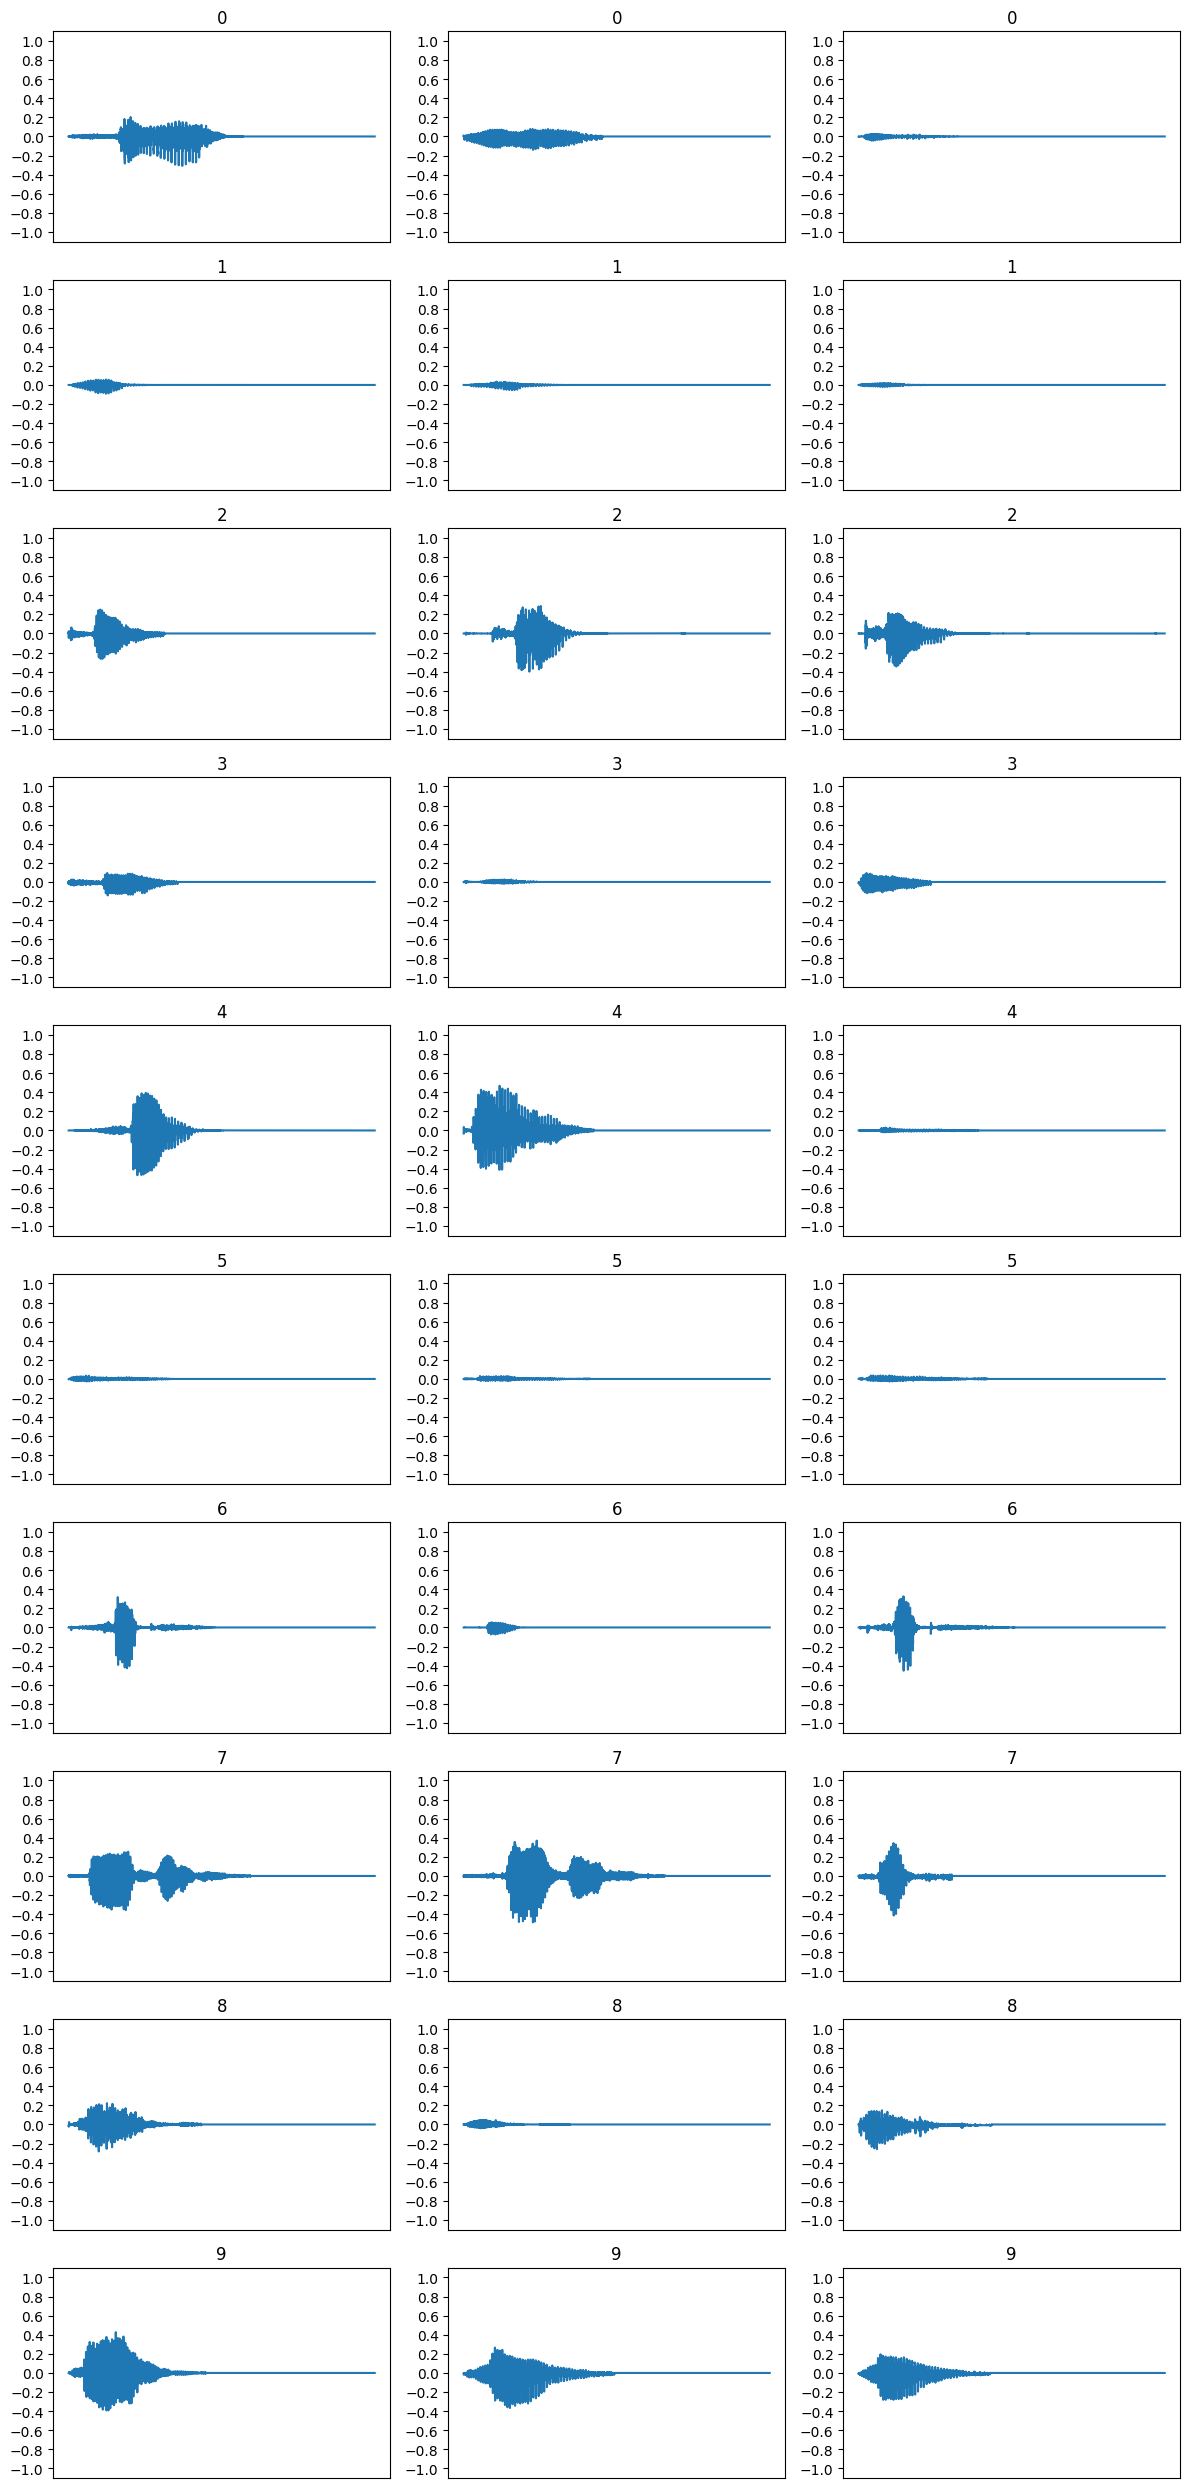

In [12]:
# Creamos un diccionario para guardar 3 audios por clase
samples_per_label = {}
num_examples_per_class = 3

# Recorremos el dataset y juntamos ejemplos por etiqueta
for audios, labels in train_ds.unbatch(): # unbatch devuelve ejemplos individuales
    label = labels.numpy()
    if label not in samples_per_label:
        samples_per_label[label] = []
    if len(samples_per_label[label]) < num_examples_per_class:
        samples_per_label[label].append(audios.numpy())
    if all(len(v) == num_examples_per_class for v in samples_per_label.values()) and \
       len(samples_per_label) == len(label_names):
        break  # Cortamos cuando ya tenemos 3 ejemplos por cada clase

# Ordenamos por etiqueta
sorted_labels = sorted(samples_per_label.keys())

# Par√°metros del gr√°fico
rows = len(sorted_labels)
cols = num_examples_per_class
plt.figure(figsize=(cols * 4, rows * 2.5))

# Ploteamos
for row, label in enumerate(sorted_labels):
    for col in range(num_examples_per_class):
        index = row * cols + col + 1
        plt.subplot(rows, cols, index)
        plt.plot(samples_per_label[label][col])
        plt.title(f"{label_names[label]}")
        plt.yticks(np.arange(-1.2, 1.2, 0.2))
        plt.ylim([-1.1, 1.1])
        plt.xticks([])

plt.tight_layout()
plt.show()

##Conversi√≥n de formas de onda a espectrogramas

El frame_length es la cantidad de muestras que abarca cada ventana de an√°lisis en la Transformada de Fourier, afectando la resoluci√≥n en frecuencia: ventanas m√°s largas mejoran la precisi√≥n para distinguir frecuencias, pero reducen la resoluci√≥n temporal. El frame_step es el salto entre ventanas consecutivas, determinando la superposici√≥n; un valor menor genera m√°s superposici√≥n y mejor continuidad temporal. Los valores 255 para frame_length y 128 para frame_step son t√≠picos para audios con frecuencia de muestreo baja/moderada (como 8kHz).  

In [13]:
def get_spectrogram(waveform):
  # Convierte la onda en un espectrograma mediante una Transformada R√°pida de Fourier (STFT)
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtiene el valor absoluto del STFT
  spectrogram = tf.abs(spectrogram)
  # Agrega una dimensi√≥n de 'canal', para que el espectrograma pueda usarse
  # como entrada tipo imagen en capas convolucionales (que esperan forma
  # ('batch_size', 'alto', 'ancho', 'canales'))
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
# Reproducci√≥n de ejemplos de audio
for i in range(10):
  label = label_names[example_labels[i]]   # Obtener la etiqueta del ejemplo i-√©simo
  waveform = example_audio[i]   # Obtener la forma de onda del ejemplo i-√©simo
  spectrogram = get_spectrogram(waveform)  # Calcular el espectrograma a partir de la forma de onda

  # Imprimir caracter√≠sticas del audio
  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 3
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 8
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 6
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 0
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 4
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 7
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 0
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


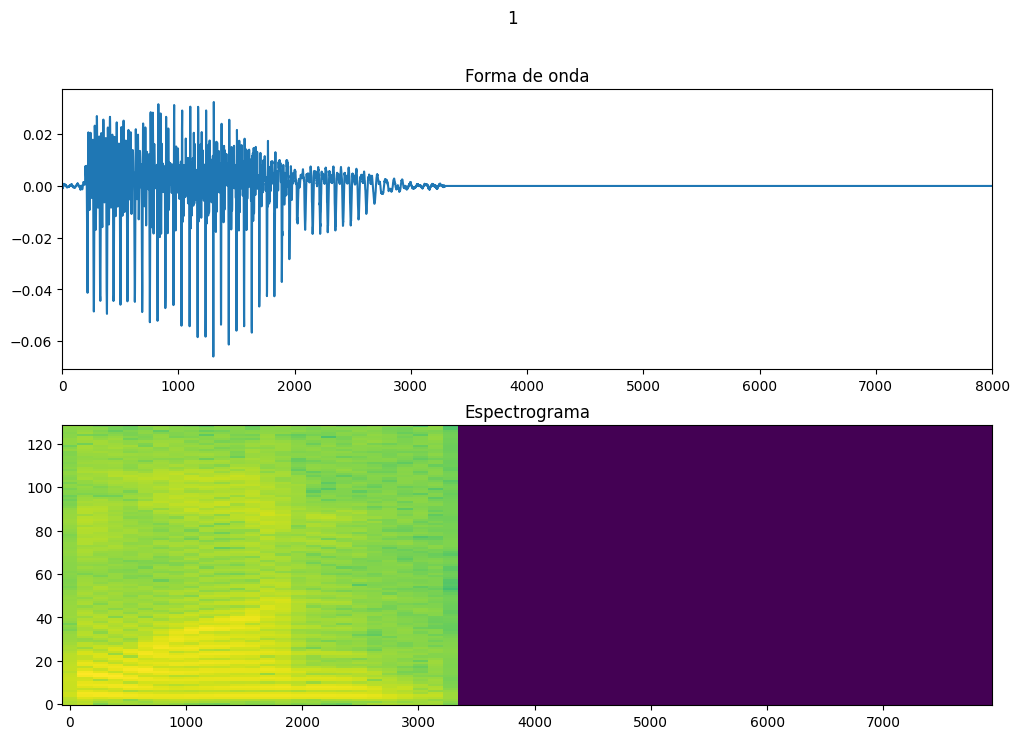

In [15]:
# Funci√≥n para graficar un espectrograma
def plot_spectrogram(spectrogram, ax):
  # Si el espectrograma tiene m√°s de 2 dimensiones, eliminamos la dimensi√≥n extra
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # Convertimos las frecuencias a escala logar√≠tmica y transponemos,
  # para que el tiempo se represente en el eje x.
  # Se suma un valor muy peque√±o (epsilon) para evitar el logaritmo de cero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)

  # Generamos los valores para los ejes X (tiempo) y Y (frecuencia)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)

  # Graficamos el espectrograma como un mapa de colores
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
# Creamos un vector de tiempo para la forma de onda
timescale = np.arange(waveform.shape[0])
# Graficamos la forma de onda en el primer subplot
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Forma de onda')
axes[0].set_xlim([0, 8000])
# Graficamos el espectrograma en el segundo subplot
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Espectrograma')
# T√≠tulo general con la etiqueta del audio
plt.suptitle(label.title())
plt.show()

Conversi√≥n de datasets de entrenamiento y validaci√≥n a espectrogramas

In [16]:
# Funci√≥n que devuelve un nuevo dataset donde cada forma de onda es convertida en espectrograma
def make_spec_ds(ds):
  # Aplica la funci√≥n get_spectrogram a cada ejemplo del dataset
  # Mantiene las etiquetas sin cambios
  # Ejecuta las llamadas en paralelo para optimizar el rendimiento
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

# Dataset de espectrogramas para entrenamiento
train_spectrogram_ds = make_spec_ds(train_ds)

# Dataset de espectrogramas para validaci√≥n
val_spectrogram_ds = make_spec_ds(val_ds)

Visualizaci√≥n de tres espectrogramas por clase

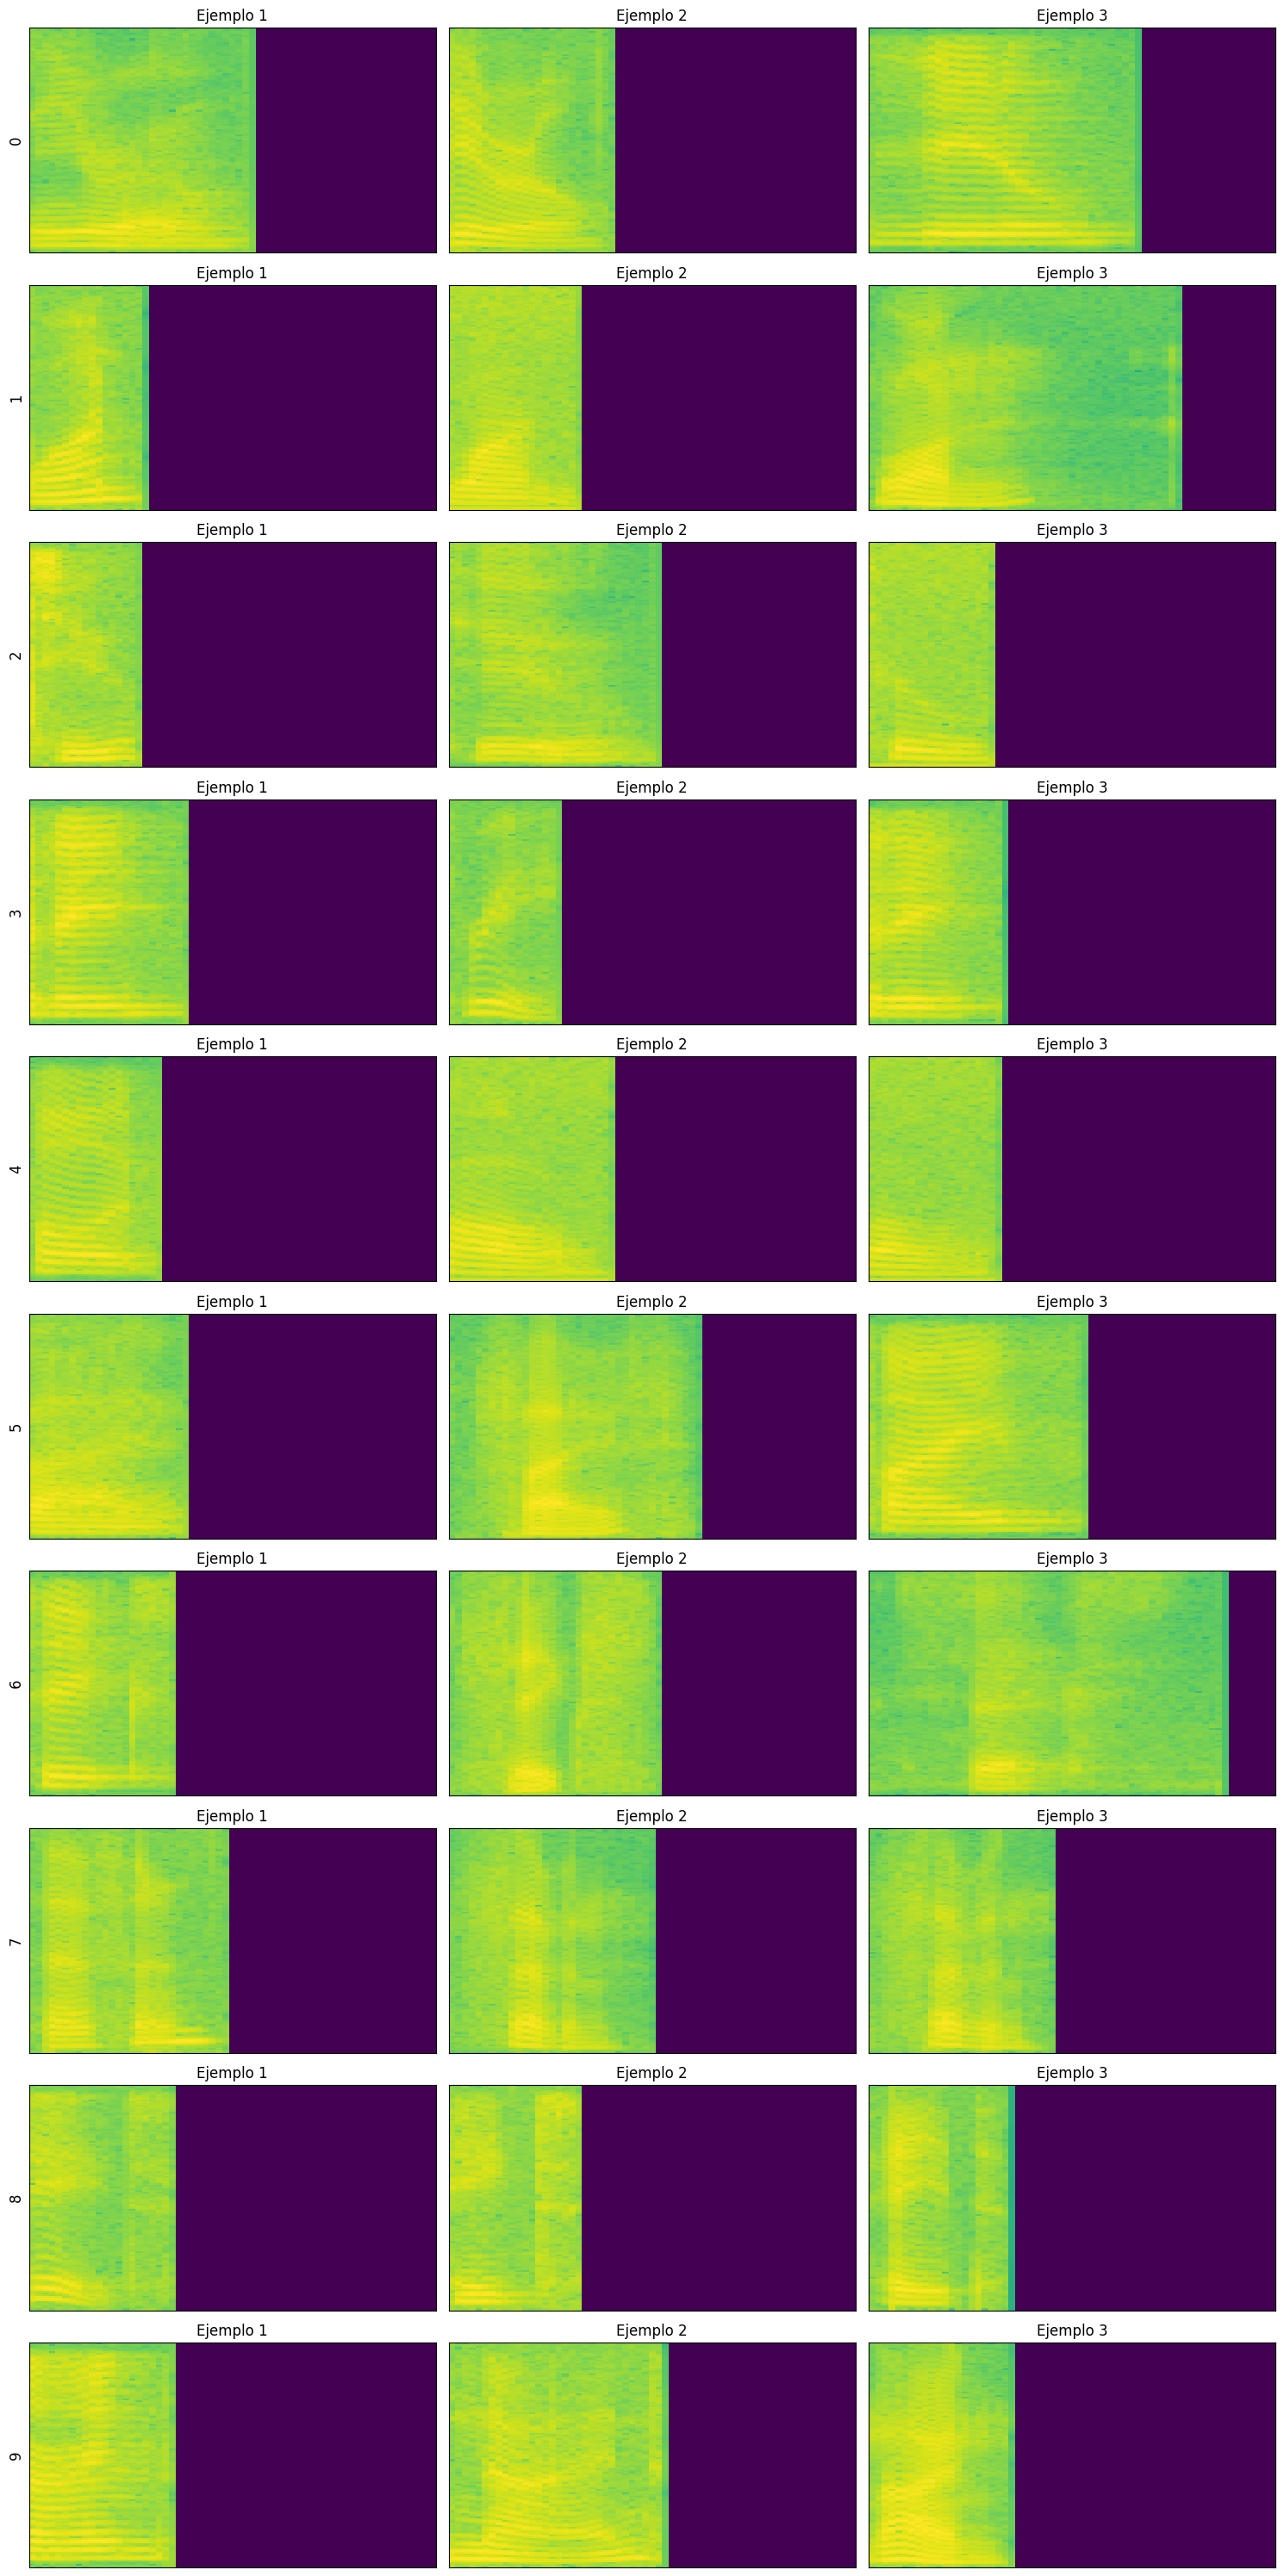

In [17]:
# Extraemos ejemplos individuales del dataset (sin batching)
unbatched_ds = train_spectrogram_ds.unbatch()

# Crear un diccionario donde la clave es la clase
# y el valor es una lista de espectrogramas que pertenecen a esa clase
ejemplos_por_clase = collections.defaultdict(list)

# Iteramos por cada par (espectrograma, etiqueta) individual del dataset
for spec, label in unbatched_ds:
    label_idx = label.numpy() # Convertimos el label de tensor a entero
    if len(ejemplos_por_clase[label_idx]) < 3:
        ejemplos_por_clase[label_idx].append(spec.numpy())

    # Cortamos si ya tenemos 3 de cada clase
    if all(len(ejemplos) == 3 for ejemplos in ejemplos_por_clase.values()) and len(ejemplos_por_clase) == len(label_names):
      break

# Configuramos la figura
rows = len(label_names)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Graficamos los espectrogramas
for label_idx, espectros in ejemplos_por_clase.items():
    for i in range(3):
        ax = axes[label_idx][i] if rows > 1 else axes[i]
        plot_spectrogram(espectros[i], ax)
        if i == 0:
            ax.set_ylabel(label_names[label_idx], fontsize=12)
        ax.set_title(f"Ejemplo {i+1}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

##CNN

###Arquitectura

Para el modelado se utilizar√° una red neuronal convolucional simple (CNN), a partir de las im√°genes de espectrogramas generadas de los archivos de audio.

In [ ]:
# NOTA: Celdas de entrenamiento comentadas para usar modelo pre-entrenado
# Descomentar solo si se necesita reentrenamiento desde cero [!]

In [ ]:
'''
# Obtenci√≥n del tama√±o del buffer para mezclar datos, equilibrando rendimiento y uso de memoria
train_size = 2400
val_size = 600
shuffle_buffer = min(1000, train_size // 2)

# Optimizaci√≥n de la carga y procesamiento de los datasets

train_spectrogram_ds = (train_spectrogram_ds
                       .cache()  # Guarda el dataset en memoria para acelerar accesos posteriores
                       .shuffle(shuffle_buffer)  # Mezcla aleatoriamente los ejemplos para mejorar el entrenamiento
                       .prefetch(tf.data.AUTOTUNE))  # Pre-carga datos mientras la GPU est√° ocupada

val_spectrogram_ds = (val_spectrogram_ds
                     .cache()  # Guarda el dataset en memoria para acelerar accesos posteriores
                     .prefetch(tf.data.AUTOTUNE))  # Pre-carga datos para mejorar eficiencia durante la validaci√≥n
'''

In [ ]:
'''
# Extraemos un batch para obtener el shape
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    break

print('Input shape:', input_shape)
num_labels = len(label_names)

# Para normalizar los datos de entrada, instanciamos la capa norm
norm_layer = layers.Normalization()
# Calculamos la media y desviaci√≥n est√°ndar de los espectrogramas de entrenamiento
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

# Definici√≥n de la arquitectura del modelo CNN
# para clasificaci√≥n de espectrogramas
model = models.Sequential([
    layers.Input(shape=input_shape),                # Capa de entrada
    layers.Resizing(32, 32),                        # Redimensiona a 32x32
    norm_layer,                                     # Normaliza datos
    layers.Conv2D(32, 3, activation='relu'),        # Conv. 32 filtros
    layers.Conv2D(64, 3, activation='relu'),        # Conv. 64 filtros
    layers.MaxPooling2D(),                          # Pooling para reducir tama√±o
    layers.Dropout(0.25),                           # Dropout 25%
    layers.Flatten(),                               # Aplana a vector 1D
    layers.Dense(128, activation='relu'),           # Capa densa 128 neuronas
    layers.Dropout(0.5),                            # Dropout 50%
    layers.Dense(num_labels, activation='softmax')  # Capa de salida con act. softmax (c. multi-clase)
])

model.summary()
'''

Input shape: (61, 129, 1)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resizing (Resizing)             ‚îÇ (None, 32, 32, 1)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ normalization (Normalization)   ‚îÇ (None, 32, 32, 1)      ‚îÇ             3 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 30, 30, 32)     ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 28, 28, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 14, 14, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 14, 14, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 12544)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ     1,605,760 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 10)             ‚îÇ         1,290 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
'''
# Compilaci√≥n del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # esperando logits con softmax
    metrics=['accuracy'],
)
'''

###Entrenamiento

In [ ]:
'''
# Entrenamiento con early stopping
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
'''

Epoch 1/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 221ms/step - accuracy: 0.2934 - loss: 2.0123 - val_accuracy: 0.6483 - val_loss: 1.2432
Epoch 2/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 205ms/step - accuracy: 0.5992 - loss: 1.2390 - val_accuracy: 0.7983 - val_loss: 0.8060
Epoch 3/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 176ms/step - accuracy: 0.7213 - loss: 0.8649 - val_accuracy: 0.8517 - val_loss: 0.6040
Epoch 4/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 210ms/step - accuracy: 0.8038 - loss: 0.6458 - val_accuracy: 0.8733 - val_loss: 0.4711
Epoch 5/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 206ms/step - accuracy: 0.8451 - loss: 0.5252 - val_accuracy: 0.9000 - val_loss: 0.3628
Epoch 6/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 182ms/step - accuracy: 0.8640 - loss: 0.4258 - val_accuracy: 0.9183 - val_loss

###Resultados

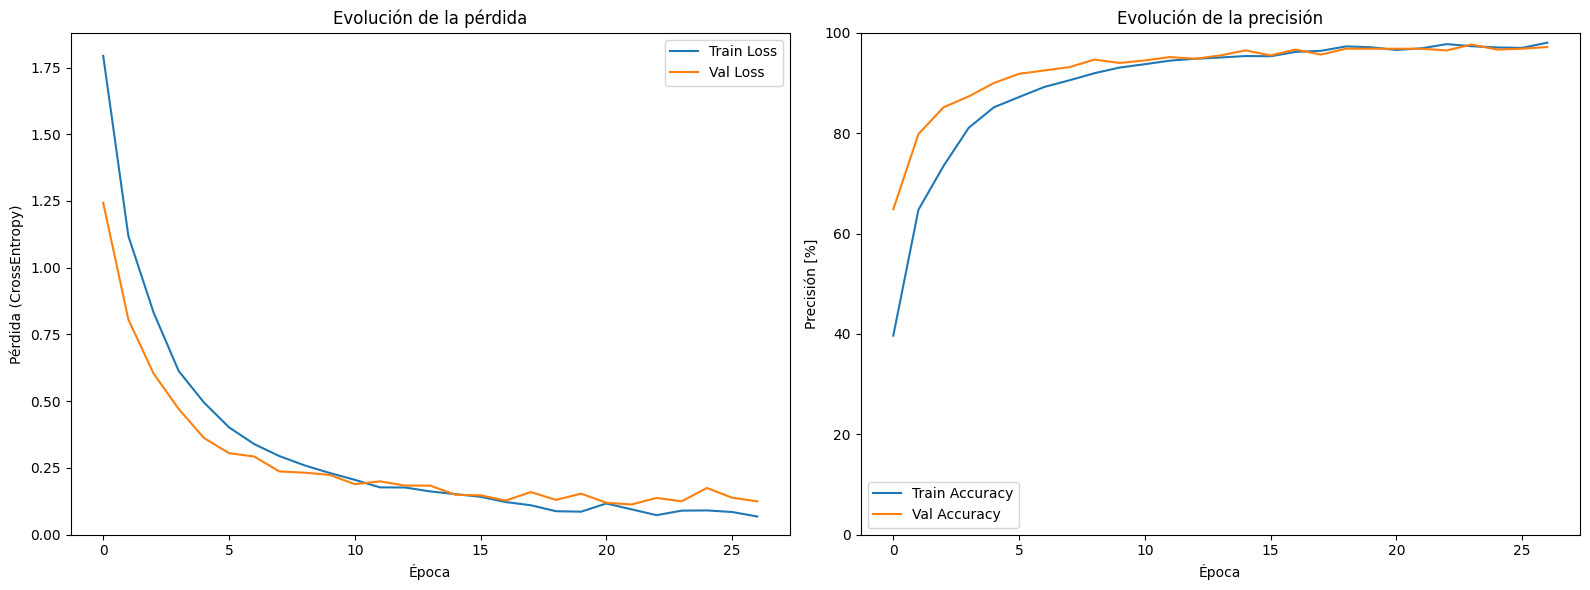

In [ ]:
'''
# Visualizaci√≥n de m√©tricas de entrenamiento y validaci√≥n
metrics = history.history
plt.figure(figsize=(16, 6))

# Gr√°fico de la funci√≥n de p√©rdida
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('√âpoca')
plt.ylabel('P√©rdida (CrossEntropy)')
plt.title('Evoluci√≥n de la p√©rdida')

# Gr√°fico de la precisi√≥n
plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), label='Train Accuracy')
plt.plot(history.epoch, 100 * np.array(metrics['val_accuracy']), label='Val Accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('√âpoca')
plt.ylabel('Precisi√≥n [%]')
plt.title('Evoluci√≥n de la precisi√≥n')

plt.tight_layout()
plt.show()
'''

üìå **An√°lisis del entrenamiento:**

* Aprendizaje efectivo en las primeras √©pocas (2‚Äì9), con mejoras constantes tanto en el set de entrenamiento como en el de validaci√≥n.

* Hasta la √©poca 10, la accuracy en validaci√≥n es superior a la de entrenamiento, lo que puede indicar buena generalizaci√≥n en las primeras etapas. Luego, ambas m√©tricas evolucionan de forma pareja.

* Las curvas de p√©rdida y precisi√≥n muestran una convergencia arm√≥nica, aunque a partir de la √©poca 16 se observa una ligera separaci√≥n en la p√©rdida, lo que podr√≠a sugerir un inicio de sobreajuste.

* En general, el entrenamiento fue exitoso: la red aprendi√≥ r√°pido y alcanz√≥ alta precisi√≥n en ambos conjuntos.

* El uso de early stopping fue acertado, previniendo un sobreentrenamiento innecesario y deteniendo el proceso oportunamente.

In [ ]:
'''
# Guardar el modelo como un archivo HDF5
model.save("model_cnn.h5")
'''

Corremos la celda a continuaci√≥n para validar el rendimiento del modelo cargado, previamente entrenado y descargado.

In [18]:
# 1. Cargar el modelo m√°s tarde, asegurando reproducibilidad
tf.keras.utils.set_random_seed(42)  # Fijar todas las semillas

model = tf.keras.models.load_model('/content/model_cnn.h5')

# 2. Recompilar id√©ntico al entrenamiento original
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 3. Evaluaci√≥n determinista
# Desactivar operaciones no deterministas frente al uso de GPU
tf.config.experimental.enable_op_determinism()

# 4. Reevaluar
results = model.evaluate(val_spectrogram_ds, verbose=0)
print(f"\nResultados finales - Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

# 5. Verificaci√≥n adicional
print("\nComparaci√≥n con entrenamiento original:")
print(f"Val Accuracy esperado: 0.9717 | Obtenido: {results[1]:.4f}")
print(f"Val Loss esperado: 0.1250 | Obtenido: {results[0]:.4f}")


Resultados finales - Loss: 0.1250, Accuracy: 0.9717

Comparaci√≥n con entrenamiento original:
Val Accuracy esperado: 0.9717 | Obtenido: 0.9717
Val Loss esperado: 0.1250 | Obtenido: 0.1250


####Matriz de confusi√≥n

Se utiliza una matriz de confusi√≥n para verificar qu√© tan bien clasific√≥ el modelo cada uno de los d√≠gitos en el conjunto de validaci√≥n:

10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 48ms/step


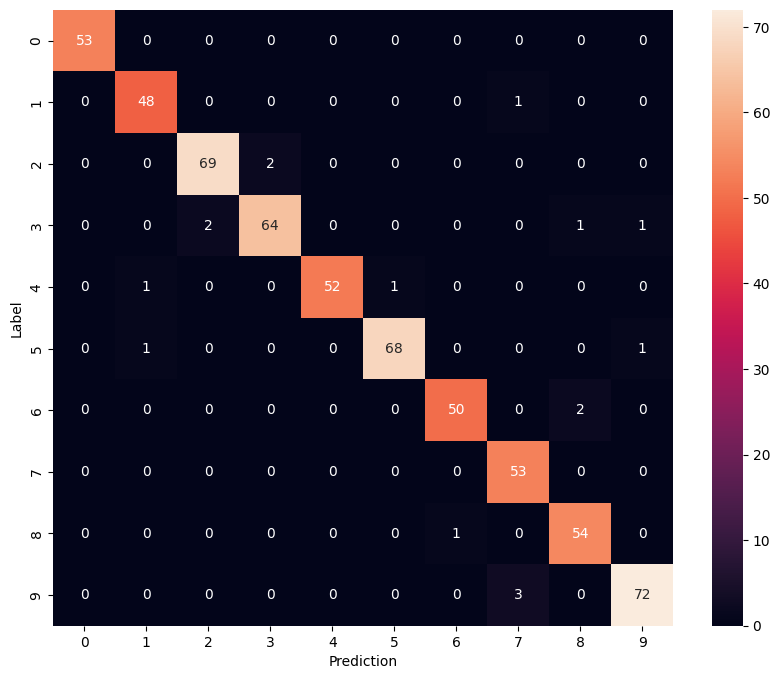

In [19]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

**Rendimiento por clase:**

* Las clases 0 y 7 tienen alta precisi√≥n. Tambi√©n 1 y 8.   

* Clases como 2, 4, 5 y 6 tienen una presici√≥n buena pero menor que las anteriores.

**Errores m√°s frecuentes:**

* La clase 9 se confundi√≥ con 7 tres veces.

***Exploramos los errores en la clasificaci√≥n de d√≠gitos:***

In [20]:
# Obtener todas las etiquetas verdaderas y las predicciones
true_labels = []
predicted_labels = []
audio_samples = []  # Guardamos las formas de onda originales

for batch in val_ds.unbatch():  # Usamos val_ds (no el de espectrogramas) para obtener el audio crudo
    audio, label = batch
    audio_samples.append(audio.numpy())
    true_labels.append(label.numpy())

# Convertir audios a espectrogramas (como lo hace el modelo)
spectrograms = np.array([get_spectrogram(audio).numpy() for audio in audio_samples])

# Predecir con el modelo
predicted_probs = model.predict(spectrograms)
predicted_labels = np.argmax(predicted_probs, axis=1)

true_labels = np.array(true_labels)

19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step


In [21]:
incorrect_indices = np.where(true_labels != predicted_labels)[0]
print(f"N√∫mero de errores: {len(incorrect_indices)}/{len(true_labels)}")

N√∫mero de errores: 17/600


In [22]:
import IPython.display as ipd

print("--- Audios mal clasificados ---")
for idx in incorrect_indices[:]:
    audio = audio_samples[idx]
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]

    print(f"\nAudio {idx}:")
    print(f"‚úÖ Etiqueta verdadera: {label_names[true_label]}")
    print(f"‚ùå Predicci√≥n del modelo: {label_names[predicted_label]}")

    # Reproducir el audio
    print("üéß Escucha:")
    ipd.display(ipd.Audio(audio, rate=8000))

--- Audios mal clasificados ---

Audio 2:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 8
üéß Escucha:



Audio 36:
‚úÖ Etiqueta verdadera: 8
‚ùå Predicci√≥n del modelo: 6
üéß Escucha:



Audio 42:
‚úÖ Etiqueta verdadera: 6
‚ùå Predicci√≥n del modelo: 8
üéß Escucha:



Audio 44:
‚úÖ Etiqueta verdadera: 4
‚ùå Predicci√≥n del modelo: 5
üéß Escucha:



Audio 54:
‚úÖ Etiqueta verdadera: 2
‚ùå Predicci√≥n del modelo: 3
üéß Escucha:



Audio 101:
‚úÖ Etiqueta verdadera: 1
‚ùå Predicci√≥n del modelo: 7
üéß Escucha:



Audio 136:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 9
üéß Escucha:



Audio 170:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 2
üéß Escucha:



Audio 205:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 2
üéß Escucha:



Audio 303:
‚úÖ Etiqueta verdadera: 5
‚ùå Predicci√≥n del modelo: 9
üéß Escucha:



Audio 304:
‚úÖ Etiqueta verdadera: 9
‚ùå Predicci√≥n del modelo: 7
üéß Escucha:



Audio 321:
‚úÖ Etiqueta verdadera: 4
‚ùå Predicci√≥n del modelo: 1
üéß Escucha:



Audio 333:
‚úÖ Etiqueta verdadera: 6
‚ùå Predicci√≥n del modelo: 8
üéß Escucha:



Audio 344:
‚úÖ Etiqueta verdadera: 5
‚ùå Predicci√≥n del modelo: 1
üéß Escucha:



Audio 432:
‚úÖ Etiqueta verdadera: 9
‚ùå Predicci√≥n del modelo: 7
üéß Escucha:



Audio 436:
‚úÖ Etiqueta verdadera: 2
‚ùå Predicci√≥n del modelo: 3
üéß Escucha:



Audio 588:
‚úÖ Etiqueta verdadera: 9
‚ùå Predicci√≥n del modelo: 7
üéß Escucha:


üìå An√°lisis de errores (17 casos):

* 12 errores atribuibles a confusi√≥n ac√∫stica (no ocurrir√≠an en clasificaci√≥n humana) ‚Üí *Patr√≥n de similitud fon√©tica detectado*

* 5 casos con discordancia etiqueta/predicci√≥n

    ‚Üí Posibles causas:

  * Error de etiquetado original

  * Ambiguidad perceptual incluso para humanos

####Predicci√≥n de audio

Se realiza una comprobaci√≥n aleatoria de clasificaci√≥n sobre el dataset original.

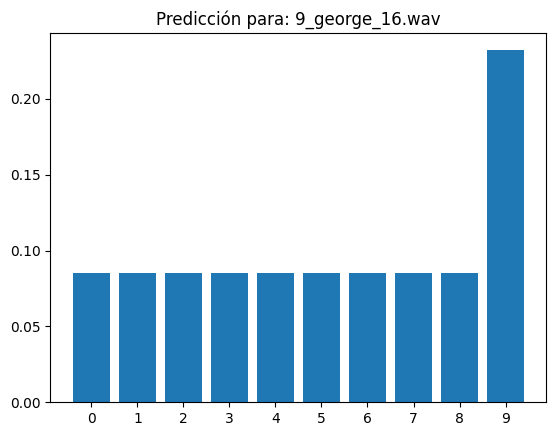

In [23]:
from pathlib import Path
data_dir = Path('organized_audio')  # Convertir a objeto Path
audio_path = data_dir / '9' / '9_george_16.wav'

# Cargar y procesar el audio
x = tf.io.read_file(str(audio_path))  # Convertir a string para tf.io.read_file
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

# Obtener el espectrograma
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# Realizar predicci√≥n
prediction = model(x)
x_labels = label_names

# Visualizar resultados
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Predicci√≥n para: 9_george_16.wav')
plt.show()

# Reproducir audio
display.display(display.Audio(waveform, rate=8000))

Las probabilidades mostradas reflejan la confianza del modelo en cada d√≠gito. **La sumatoria de las probabilidades siempre ser√° 1.**

##RNN

Se dise√±a una red recurrente para la clasificaci√≥n de audio.

In [ ]:
# NOTA: Celdas de entrenamiento comentadas para usar modelo pre-entrenado
# Descomentar solo si se necesita reentrenamiento desde cero [!]

In [ ]:
'''
# ---------- Preprocesamiento ----------
def preprocess_rnn_data(spectrogram, label):
    """
    Preprocesa los datos para una RNN:
    - Elimina la dimensi√≥n del canal
    - Normaliza por muestra
    """
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # De (batch, tiempo, caracter√≠sticas, 1) a (batch, tiempo, caracter√≠sticas)

    # Normalizaci√≥n por muestra
    mean = tf.reduce_mean(spectrogram, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(spectrogram, axis=[1, 2], keepdims=True)
    spectrogram = (spectrogram - mean) / (std + 1e-6)  # A√±adir epsilon para evitar divisi√≥n por cero

    return spectrogram, label
'''

In [ ]:
'''
# Mostrar forma de ejemplo
for spec, _ in train_spectrogram_ds.take(1):
    print(f"Forma del espectrograma de ejemplo: {spec.shape}")
'''

Forma del espectrograma de ejemplo: (64, 61, 129, 1)


In [ ]:
'''
# Aplicar el preprocesamiento
train_rnn_ds = train_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
val_rnn_ds = val_spectrogram_ds.map(preprocess_rnn_data, num_parallel_calls=tf.data.AUTOTUNE)
'''

###Arquitectura

Se dise√±a una red recurrente para la clasificaci√≥n de audio.

In [ ]:
'''
# ---------- Definici√≥n del modelo ----------
input_shape = next(iter(train_rnn_ds.take(1)))[0].shape[1:]  # (timesteps, features)
num_labels_rnn = len(label_names)

model_rnn = models.Sequential([
    layers.Input(shape=input_shape),  # input_shape: (tiempo, caracter√≠sticas)

    # Primera capa LSTM
    layers.LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),

    # Segunda capa LSTM
    layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1),

    # Batch Normalization
    layers.BatchNormalization(),

    # Capa densa + Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(num_labels_rnn, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model_rnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()
'''

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_2 (LSTM)                   ‚îÇ (None, 61, 256)        ‚îÇ       395,264 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_3 (LSTM)                   ‚îÇ (None, 128)            ‚îÇ       197,120 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 10)             ‚îÇ           650 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 601,802 (2.30 MB)

 Trainable params: 601,546 (2.29 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
'''
# ---------- Callbacks ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )
]
'''

###Entrenamiento

In [ ]:
'''
EPOCHS = 50
history_rnn = model_rnn.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
'''

Epoch 1/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50s 1s/step - accuracy: 0.1486 - loss: 2.7024 - val_accuracy: 0.1233 - val_loss: 2.2801 - learning_rate: 5.0000e-04
Epoch 2/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 1s/step - accuracy: 0.1873 - loss: 2.3547 - val_accuracy: 0.2350 - val_loss: 2.1721 - learning_rate: 5.0000e-04
Epoch 3/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 1s/step - accuracy: 0.2743 - loss: 1.9607 - val_accuracy: 0.2483 - val_loss: 1.9564 - learning_rate: 5.0000e-04
Epoch 4/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 986ms/step - accuracy: 0.3474 - loss: 1.7035 - val_accuracy: 0.4967 - val_loss: 1.7042 - learning_rate: 5.0000e-04
Epoch 5/50
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 995ms/step - accuracy: 0.4247 - loss: 1.4382 - val_accuracy: 0.5067 - val_loss: 1.3161 - learning_rate: 5.0000e-04
Epoch 6/50
38/38 ‚îÅ‚îÅ‚

###Resultados

In [ ]:
'''
# ---------- Mejor √©poca ----------
best_epoch_index = history_rnn.history['val_loss'].index(min(history_rnn.history['val_loss']))

print(f"\nMejor √©poca restaurada: {best_epoch_index + 1}")
print(f"Entrenamiento -> Loss: {history_rnn.history['loss'][best_epoch_index]:.4f} - Accuracy: {history_rnn.history['accuracy'][best_epoch_index]:.4f}")
print(f"Validaci√≥n -> Loss: {history_rnn.history['val_loss'][best_epoch_index]:.4f} - Accuracy: {history_rnn.history['val_accuracy'][best_epoch_index]:.4f}")
'''


Mejor √©poca restaurada: 24
Entrenamiento -> Loss: 0.0740 - Accuracy: 0.9879
Validaci√≥n -> Loss: 0.0471 - Accuracy: 0.9900


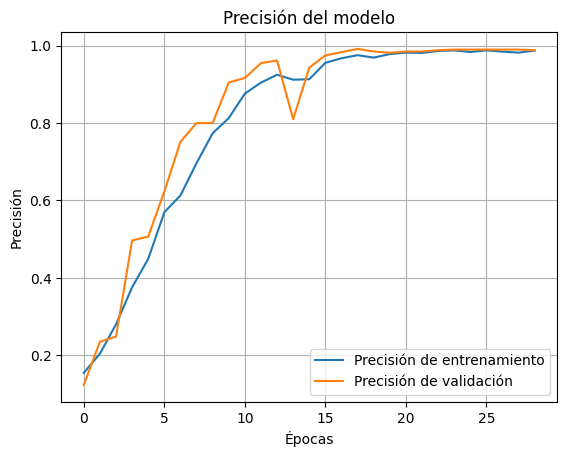

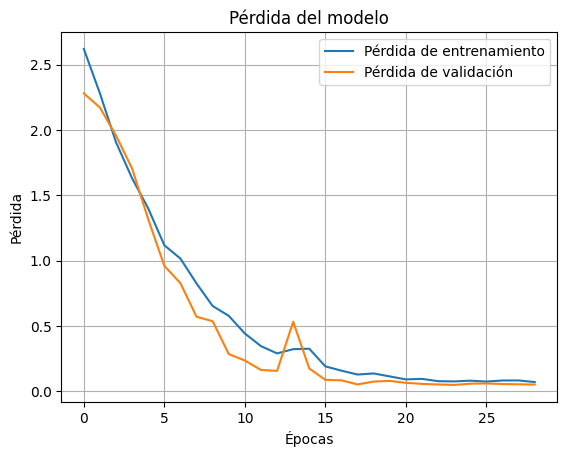

In [ ]:
'''
# ---------- Gr√°ficos ----------
plt.plot(history_rnn.history['accuracy'], label='Precisi√≥n de entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisi√≥n de validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.title('Precisi√≥n del modelo')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history_rnn.history['loss'], label='P√©rdida de entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='P√©rdida de validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.title('P√©rdida del modelo')
plt.grid(True)
plt.legend()
plt.show()
'''

üìå **An√°lisis del entrenamiento:**

* Fase inicial (√©pocas 1-6):

  * Aprendizaje lento pero constante

  * Gran salto en val_accuracy (49.6%) en √©poca 4

  * P√©rdidas disminuyen r√°pidamente (val_loss de 2.28 ‚Üí 0.96)

* Fase de crecimiento (√©pocas 7-12):

  * Mejora acelerada (val_accuracy sube de 75% a 95.5%)

  * Reducci√≥n dr√°stica de val_loss (0.83 ‚Üí 0.16)

  * Train y val convergen arm√≥nicamente

* Estabilizaci√≥n (√©pocas 13+):

  * M√°ximo rendimiento alcanzado (val_accuracy 96-99%)

  * Fluctuaci√≥n en validaci√≥n en √©poca 14 (posible outlier)
    * ‚¨áÔ∏è Ca√≠da abrupta en val_accuracy
    * ‚¨ÜÔ∏è Aumento significativo en val_loss



üìå **Conclusiones clave:**

  ‚úì La red super√≥ el 90% de val_accuracy en solo 10 √©pocas

  ‚úì Excelente generalizaci√≥n (gap m√≠nimo train-val en √∫ltimas √©pocas)

  ‚úì Los ajustes autom√°ticos de LR optimizaron la convergencia final

  ‚úì Entrenamiento eficiente con early stopping impl√≠cito

####Matriz de confusi√≥n

Se utiliza una matriz de confusi√≥n para verificar qu√© tan bien clasific√≥ el modelo cada uno de los d√≠gitos en el conjunto de validaci√≥n:

10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 226ms/step


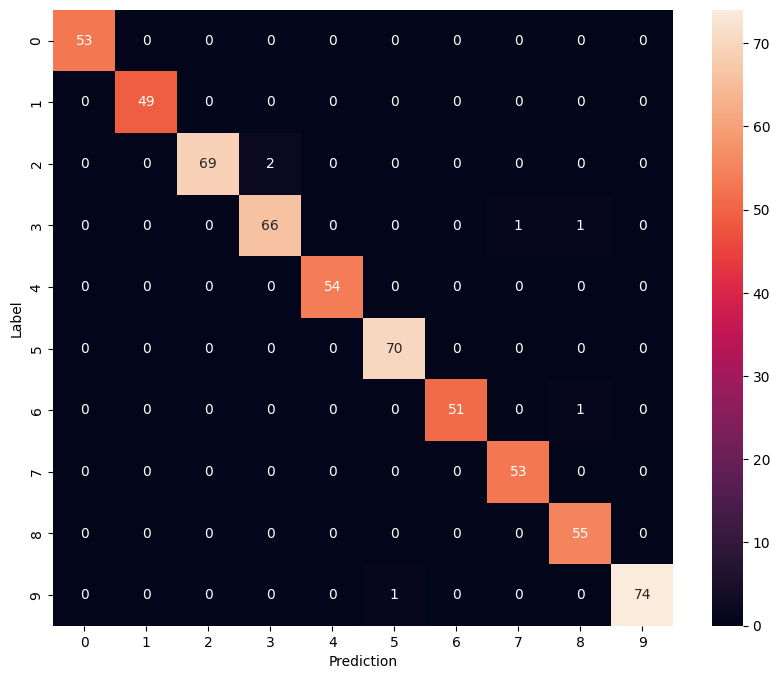

In [ ]:
'''
# ---------- Predicciones ----------
y_pred_rnn = model_rnn.predict(val_rnn_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

# ---------- Etiquetas verdaderas ----------
y_true_rnn = tf.concat([labels for _, labels in val_rnn_ds], axis=0)

# ---------- Matriz de Confusi√≥n ----------
confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
'''

In [ ]:
'''
# Se guarda el modelo como un archivo HDF5
model_rnn.save("model_rnn.h5")
'''

*Exploramos los errores en la clasificaci√≥n de d√≠gitos:*

In [ ]:
'''
# Obtener predicciones y etiquetas reales
y_true = np.concatenate([y.numpy() for _, y in val_rnn_ds])
y_pred = np.argmax(model_rnn.predict(val_rnn_ds), axis=1)

# Identificar errores
error_indices = np.where(y_true != y_pred)[0]
audio_samples = [audio.numpy() for audio, _ in val_ds.unbatch()]

print(f"\n Errores encontrados: {len(error_indices)}/{len(y_true)}")

# Mostrar cada error en el formato solicitado
for i, idx in enumerate(error_indices):
    audio = audio_samples[idx]
    true_label = y_true[idx]
    predicted_label = y_pred[idx]

    print(f"\nAudio {idx}:")
    print(f"‚úÖ Etiqueta verdadera: {label_names[true_label]}")
    print(f"‚ùå Predicci√≥n del modelo: {label_names[predicted_label]}")

    # Reproducir audio
    print("üéß Escucha:")
    display.display(display.Audio(audio, rate=8000, autoplay=False))
'''

10/10 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 241ms/step

 Errores encontrados: 6/600

Audio 2:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 8
üéß Escucha:



Audio 156:
‚úÖ Etiqueta verdadera: 3
‚ùå Predicci√≥n del modelo: 7
üéß Escucha:



Audio 304:
‚úÖ Etiqueta verdadera: 9
‚ùå Predicci√≥n del modelo: 5
üéß Escucha:



Audio 333:
‚úÖ Etiqueta verdadera: 6
‚ùå Predicci√≥n del modelo: 8
üéß Escucha:



Audio 436:
‚úÖ Etiqueta verdadera: 2
‚ùå Predicci√≥n del modelo: 3
üéß Escucha:



Audio 512:
‚úÖ Etiqueta verdadera: 2
‚ùå Predicci√≥n del modelo: 3
üéß Escucha:


**Errores detectados (6 casos):**

üìå Coincidentes con CNN (4):

  - 2 audios mal etiquetados desde origen

  - 2 dif√≠ciles de clasificar por ambos modelos (casos l√≠mite)

üìå No coincidentes (2):

  - 2 audios bien clasificados por CNN

## **Conclusiones: Comparaci√≥n CNN vs RNN**

üìå **Rendimiento Final**  
- **CNN**:  
  - *Mejor val_accuracy*: **97.17%** (√©poca 27)  
  - *Velocidad*: Entrenamiento m√°s r√°pido (~8s/√©poca)  
  - *Estabilidad*: Progreso constante sin fluctuaciones bruscas  

- **RNN**:  
  - *Mejor val_accuracy*: **99.00%** (√©poca 24)  
  - *Velocidad*: Entrenamiento m√°s lento (~40s/√©poca)  
  - *Din√°mica*: Mayor variabilidad (ej. outlier √©poca 14)  

<br>

üìå **Patrones de Aprendizaje**  
1. **CNN**:  
   - Aprendizaje acelerado en primeras √©pocas (val_accuracy >90% en √©poca 10)  
   - Curvas suaves de loss/accuracy  
   - Early stopping en √©poca 27 por estabilizaci√≥n  

2. **RNN**:  
   - Comienzo lento (val_accuracy 12.3% en √©poca 1)  
   - Salto abrupto en √©poca 10 (80.0% ‚Üí 90.5%)  
   - M√∫ltiples ajustes de learning rate (5 reducciones)  
   - Early stopping en √©poca 29 (mejor modelo en √©poca 24)  

<br>

üìå **Hallazgos Clave**    

  1. La **RNN super√≥** levemente a la CNN en accuracy final (99.0% vs 97.2%)
  2. La **CNN fue m√°s estable** (sin grandes fluctuaciones en validaci√≥n)
  3. Ambas arquitecturas mostraron **buena generalizaci√≥n** (gaps train-val)  

<br>

üìå **Insights finales**  
1. Para aplicaciones que priorizan **velocidad**: Usar CNN  
2. Para m√°xima **precisi√≥n**: Optar por RNN (con m√°s recursos computacionales
3. Ambos modelos son exitosos (>95% val_accuracy), demostrando que las arquitecturas CNN y RNN son efectivas para clasificaci√≥n de audio  